In [1]:
#All imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import logging
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def calibrate():
    # Read the images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    # Array to store object points and image points from all the images
    objpoints = []
    imgpoints = []

    # Prepare object points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

In [3]:
def color_gradient(img, s_thresh=(90, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
        
    # Sobel x and y
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    
    # Gradient magnitud
    magnitude = np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(magnitude)/255 
    gradmag = (magnitude/scale_factor).astype(np.uint8) 
    
    # Threshold x gradient
    sxbinary = np.zeros_like(gradmag)
    sxbinary[(gradmag >= sx_thresh[0]) & (gradmag <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [4]:
def warp(image):
    img_size = (image.shape[1], image.shape[0])

    top_left = [570,470]
    top_right = [720, 470]
    bottom_right = [1130,720]
    bottom_left = [200,720]
    src = np.array([bottom_left,bottom_right,top_right,top_left])

    top_left_dst = [320,0]
    top_right_dst = [1080,0]
    bottom_right_dst = [1080,720]
    bottom_left_dst = [320,720]
    dst = np.array([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst])

    src = np.float32(src.tolist())
    dst = np.float32(dst.tolist())
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [75]:
def average_curvature(ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    average = (left_curverad + right_curverad) / 2
    return average

In [80]:
def offset(left_fitx, right_fitx, center):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    left_fitx_zero = left_fitx[0]
    right_fitx_zero = right_fitx[0]
    lane_center = (right_fitx_zero - left_fitx_zero) / 2
    offset_pixels = center - lane_center
    
    return offset_pixels * ym_per_pix

In [81]:
 def draw_lane(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8')
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    if not righty.any():
        return img
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    top_left = [570,470]
    top_right = [720, 470]
    bottom_right = [1130,720]
    bottom_left = [200,720]
    pts = np.array([bottom_left,bottom_right,top_right,top_left],np.float32)

    top_left_dst = [320,0]
    top_right_dst = [1080,0]
    bottom_right_dst = [1080,720]
    bottom_left_dst = [320,720]
    dst_pts = np.array([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst],np.float32)
    Minv = cv2.getPerspectiveTransform(dst_pts, pts)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    average_curv = average_curvature(ploty, left_fitx, right_fitx)
    offset_value = offset(left_fitx, right_fitx, img.shape[0]/2)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(result,'Lane curvature: ' + str(average_curv) + 'm',(30,60), font, 2,(255,255,255),2)
    cv2.putText(result,'Offset: ' + str(offset_value) + 'm',(30,120), font, 2,(255,255,255),2)
     
    return result

In [82]:
def pipeline(image):
    
    global img
    img = image
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #3. Color and gradient threshold
    result = color_gradient(undist)
    #4. Perpective transform
    binary_warped = warp(result)
    #5. Draw lane
    result = draw_lane(binary_warped)
    
    
    return result

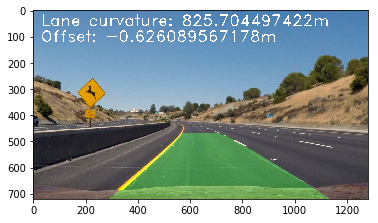

In [83]:
#1.Calibrate camera 
# ret, mtx, dist, rvecs, tvecs = calibrate()

# image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread('test_images/test2.jpg')
result = pipeline(image)

# undist = cv2.undistort(image, mtx, dist, None, mtx)
#     #3. Color and gradient threshold
# result = color_gradient(undist)
#     #4. Perpective transform
# binary_warped = warp(result)

# final = draw_lane(binary_warped)

plt.imshow(result,cmap='gray')

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# ax1.imshow(image)
# ax1.set_title('Original Image', fontsize=50)
# ax2.imshow(result, cmap='gray')
# ax2.set_title('Warped Image', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [84]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#1.Calibrate camera 
ret, mtx, dist, rvecs, tvecs = calibrate()

img = mpimg.imread('test_images/test2.jpg')

output = 'output.mp4'
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



100%|█████████▉| 1260/1261 [02:47<00:00,  7.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 3min 22s, sys: 42.5 s, total: 4min 4s
Wall time: 2min 48s
